In [33]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline,make_pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Bidirectional
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

In [34]:
CFG = [
    '/kaggle/input/software-effort-estimation-datasets/albrecht.csv',
    '/kaggle/input/software-effort-estimation-datasets/china.csv',
    '/kaggle/input/software-effort-estimation-datasets/desharnais.csv',
    '/kaggle/input/software-effort-estimation-datasets/finnish.csv',
    '/kaggle/input/software-effort-estimation-datasets/isbsg10.csv',
    '/kaggle/input/software-effort-estimation-datasets/kemerer.csv',
    '/kaggle/input/software-effort-estimation-datasets/kitchenham.csv',
    '/kaggle/input/software-effort-estimation-datasets/maxwell.csv',
    '/kaggle/input/software-effort-estimation-datasets/miyazaki94.csv'
]

In [35]:
cocomo_path= '/kaggle/input/cocomo/5.cocomo81.csv'

In [36]:
def load_cocomo_data():
    data = pd.read_csv(cocomo_path)
    X = data.iloc[:, :-1].values  # Features
    y = data.iloc[:, -1].values  # Effort
    return X, y

X, y = load_cocomo_data()

# Data Preprocessing

In [6]:
def data_albrecht():
    df = pd.read_csv(CFG[0])
    df_for_training = df.astype(float)
    #LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
    # normalize the dataset
    scaler = MinMaxScaler()
    scaler = scaler.fit(df_for_training)
    df_for_training_scaled = scaler.transform(df_for_training)
    return df


def data_china():
    
    df = pd.read_csv(CFG[1])
    df = df.drop(columns=['id','ID'])
    df_for_training = df.astype(float)
#     print(df.columns)
    #LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(df_for_training)
    df_for_training_scaled = scaler.transform(df_for_training)
    
    trainX = []
    trainY = []
    n_future = 2   # Number of days we want to look into the future based on the past days.
    n_past = 2 # Number of past days we want to use to predict the future.

    for i in range(n_past, len(df_for_training_scaled) - n_future +1):
        trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
        trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, df_for_training.shape[1] - 1])

    trainX, trainY = np.array(trainX), np.array(trainY)

    return trainX, trainY


def data_desharnais():
    df = pd.read_csv(CFG[2])
    df = df.drop(columns=['Project','YearEnd', 'Language'])
    df_for_training = df.astype(float)
    #LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
    # normalize the dataset
    scaler = StandardScaler()
    scaler = scaler.fit(df_for_training)
    df_for_training_scaled = scaler.transform(df_for_training)
    return df


def data_finnish():
    df = pd.read_csv(CFG[3])
    df_for_training = df.astype(float)
    #LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
    # normalize the dataset
    scaler = MinMaxScaler()
    scaler = scaler.fit(df_for_training)
    df_for_training_scaled = scaler.transform(df_for_training)
    return df


def data_isbsg10():

    df = pd.read_csv(CFG[4])
    df = df.drop(columns = ['id', 'ID', 'Data_Quality', 'Year','AG', 'N_effort_level1',
           'N_PDR1', 'SDR', 'PET', 'PIT', 'I_Date', 'PAS',
           'Recording_Method', 'Resource_Level', 'MTS', 'ATS', 'R_PWE_NPA',
           'P_UWE', 'CASE_Tool', 'UM', 'HMA', 'Hardware1',
           'IDE', 'DT1', 'DBS1', 'CS1', 'WS1', 'MS1', 'OP1', 'RTA',
           'SP_CMMI', 'SP_ISO', 'SP_TICKIT', 'MIN_Defects', 'MAJ_Defects',
           'X_Defects', 'TOT_Defects', 'UB_BU', 'UB_L', 'UB_DU', 'UB_CU',
           'IMarket', 'T_Platform', 'D_Embedded', 'SE', 'SEA', 'SEM', 'E_Estimate',
           'E_Estimate_Method', 'DDE', 'DDEM', 'C_Estimate', 'CEC', 'CEM',
           'E_Tool', 'E_Comments', 'EC_Date', 'SR?', 'SR', 'R_FPC', 'R_FPA',
           'P_Defects', 'D_Defects', 'MIN_B_Defects', 'MAJ_B_Defects',
           'X_B_Defects', 'TOT_B_Defects', 'MIN_T_Defects', 'MAJ_T_Defects',
           'X_T_Defects', 'TOT_T_Defects','S_Defects', 'MIN_I_Defects', 'MAJ_I_Defects',
           'X_I_Defects', 'TOT_I_Defects'], axis = 1)
    # Replace "?" with numpy.nan
    df.replace('?', np.nan, inplace=True)
#     print(df.columns)
    
    # imputation transformer
    trf1 = ColumnTransformer([
        ('impute',SimpleImputer(strategy='constant', fill_value='Missing'),[14,15,16,17,18])
    ],remainder='passthrough')
    
    trf2 = ColumnTransformer([
    ('ohe',OneHotEncoder(sparse_output=False,drop= 'first'),[0,1,2,3,4,5,6,7,8,9,10,11,12,13,15])
    ],remainder='passthrough')
    
    pipe = Pipeline([
    ('trf1',trf1),
    ('trf2',trf2),
    ])
    
    pipe.fit_transform(df)
    
    return pipe.fit_transform(df)


def data_kemerer():
    df = pd.read_csv(CFG[5])
    df_for_training = df.astype(float)
    #LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
    # normalize the dataset
    scaler = StandardScaler()
    scaler = scaler.fit(df_for_training)
    df_for_training_scaled = scaler.transform(df_for_training)
    return df
    

    
def data_kitchenham():
    df = pd.read_csv(CFG[6])
    df_for_training = df.astype(float)
    #LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
    # normalize the dataset
    scaler = MinMaxScaler()
    scaler = scaler.fit(df_for_training)
    df_for_training_scaled = scaler.transform(df_for_training)
    return df


def data_maxwell():
    df = pd.read_csv(CFG[7])
    df_for_training = df.astype(float)
    #LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
    # normalize the dataset
    scaler = StandardScaler()
    scaler = scaler.fit(df_for_training)
    df_for_training_scaled = scaler.transform(df_for_training)
    return df


def data_miyazaki():
    df = pd.read_csv(CFG[8])
    df_for_training = df.astype(float)
    #LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
    # normalize the dataset
    scaler = StandardScaler()
    scaler = scaler.fit(df_for_training)
    df_for_training_scaled = scaler.transform(df_for_training)
    return df


In [37]:
import pywt

In [38]:
def morlet_wavelet(t, f0=1.0, sigma=1.0):
    """
    Morlet wavelet function.
    t: time variable
    f0: center frequency
    sigma: bandwidth parameter
    """
    return np.exp(-0.5 * (t / sigma) ** 2) * np.cos(2 * np.pi * f0 * t)

In [39]:
from tensorflow.keras.layers import Layer

In [56]:
class MorletWaveletLayer(Layer):
    def __init__(self, units, w=5.0, **kwargs):
        super(MorletWaveletLayer, self).__init__(**kwargs)
        self.units = units
        self.w = w

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[-1], self.units),
                                      initializer='glorot_uniform',
                                      trainable=True)

    def call(self, inputs):
        # Reshape inputs to 2D for the dense operation
        input_reshaped = tf.reshape(inputs, [-1, inputs.shape[-1]])
        z = tf.matmul(input_reshaped, self.kernel)

        # Implement Morlet wavelet using TensorFlow operations
        wavelet_output = tf.cos(self.w * z) * tf.exp(-z**2 / 2)
        
        # Reshape back to 3D
        final= tf.reshape(wavelet_output, tf.concat([tf.shape(inputs)[:-1], [self.units]], axis=0))
        print(final.shape)
        return final

In [40]:
class MorletWaveletLayer(Layer):
    def __init__(self, filters, f0=1.0, sigma=1.0, **kwargs):
        super(MorletWaveletLayer, self).__init__(**kwargs)
        self.filters = filters
        self.f0 = f0
        self.sigma = sigma

    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(self.filters, input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True,
        )
        self.built = True

    def call(self, inputs):
        time = np.linspace(-1, 1, inputs.shape[1])
        wavelet = morlet_wavelet(time, self.f0, self.sigma)
        wavelet = tf.convert_to_tensor(wavelet, dtype=tf.float32)
        wavelet = tf.reshape(wavelet, (1, -1, 1))
        
        wavelet_kernels = wavelet * tf.expand_dims(self.kernel, axis=1)
        
        # Ensure the wavelet kernels are properly shaped for convolution
        wavelet_kernels = tf.transpose(wavelet_kernels, [1, 2, 0])
        
        conv = tf.nn.conv1d(inputs, wavelet_kernels, stride=1, padding='SAME')
        return conv


In [41]:
totalX, totalY = load_cocomo_data()

In [42]:
import numpy as np

class FireflyAlgorithm:
    def __init__(self, n_fireflies, n_iterations, alpha=0.5, beta=1.0, gamma=1.0):
        self.n_fireflies = n_fireflies
        self.n_iterations = n_iterations
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def initialize_fireflies(self, bounds):
        fireflies = np.random.rand(self.n_fireflies, len(bounds))
        for i in range(len(bounds)):
            fireflies[:, i] = bounds[i][0] + fireflies[:, i] * (bounds[i][1] - bounds[i][0])
        return fireflies

    def calculate_light_intensity(self, firefly, objective_function):
        return objective_function(firefly)

    def move_firefly(self, firefly_i, firefly_j, beta):
        r = np.linalg.norm(firefly_i - firefly_j)
        return firefly_i + beta * np.exp(-self.gamma * r ** 2) * (firefly_j - firefly_i) + self.alpha * (np.random.rand(len(firefly_i)) - 0.5)

    def optimize(self, objective_function, bounds):
        fireflies = self.initialize_fireflies(bounds)
        light_intensities = np.array([self.calculate_light_intensity(firefly, objective_function) for firefly in fireflies])

        for iteration in range(self.n_iterations):
            for i in range(self.n_fireflies):
                for j in range(self.n_fireflies):
                    if light_intensities[i] > light_intensities[j]:
                        fireflies[i] = self.move_firefly(fireflies[i], fireflies[j], self.beta)
                        light_intensities[i] = self.calculate_light_intensity(fireflies[i], objective_function)
        
        best_firefly = fireflies[np.argmin(light_intensities)]
        best_intensity = np.min(light_intensities)

        return best_firefly, best_intensity


In [29]:
trainX, testX, trainY, testY = train_test_split(totalX, totalY, test_size=0.25, random_state=42)

# Define the objective function
def objective_function(params):
    f0, sigma = params[0], params[1]
    
    # Create the Wavelet Neural Network
    input_shape = trainX.shape[1:]  # Assuming trainX.shape is (496, 2, 18), input_shape should be (2, 18)
    wnn = Sequential([
        BatchNormalization(input_shape=input_shape),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        MorletWaveletLayer(filters=16, f0=1.0, sigma=1.0, input_shape=(None, 1)),  # Replace with appropriate units for your use case
        Flatten(),
        Dense(1)  # Adjust output dim to match trainY.shape[1]
    ])

    # Compile the model
    wnn.compile(optimizer='adam', loss='mse')
    #wnn.summary()
    wnn.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)
    
    loss = wnn.evaluate(testX, testY, verbose=0)
    return loss


In [30]:
# Define the bounds for f0 and sigma
bounds = [(0.1, 2.0), (0.1, 2.0)]

# Initialize the Firefly Algorithm
fa = FireflyAlgorithm(n_fireflies=10, n_iterations=2, alpha=0.5, beta=1.0, gamma=1.0)

# Optimize the parameters
best_params, best_intensity = fa.optimize(objective_function, bounds)

print(f'Best Parameters: f0 = {best_params[0]}, sigma = {best_params[1]}')
print(f'Best Intensity (MSE): {best_intensity}')


Best Parameters: f0 = 1.1146447619981164, sigma = 1.47110742508247
Best Intensity (MSE): 0.015662431716918945


In [ ]:
def objective_function(weights, model, X_train, y_train):
    model.set_weights(weights)
    predictions = model.predict(X_train)
    return mean_squared_error(y_train, predictions)

In [ ]:
from fireflyalgorithm import FireflyAlgorithm

In [ ]:
FA = FireflyAlgorithm()
best = FA.run(function=lambda weights: objective_function(weights, wnn, trainX, trainY), dim=10, lb=-5, ub=5, max_evals=10000)

In [ ]:
    firefly_optimizer = FireflyAlgorithm(
        func=lambda weights: objective_function(weights, wnn, trainX, trainY),
        lb=-1.0,
        ub=1.0,
        dim=wnn.count_params(),
        n_fireflies=20,
        max_iter=100
    )

In [61]:
    # Create the Wavelet Neural Network
    input_shape = trainX.shape[1]  # Assuming trainX.shape is (496, 2, 18), input_shape should be (2, 18)
    wnn = Sequential([
        BatchNormalization(input_shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        MorletWaveletLayer(10),  # Replace with appropriate units for your use case
        Dense(1)  # Adjust output dim to match trainY.shape[1]
    ])

(None, 10)


In [62]:
wnn.compile(optimizer='adam', loss='mse')

In [63]:
wnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_10 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dense_492 (Dense)           (None, 64)                1088      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_493 (Dense)           (None, 32)                2080      
                                                                 
 morlet_wavelet_layer_8 (Mor  (None, 10)               320       
 letWaveletLayer)                                                
                                                                 
 dense_494 (Dense)           (None, 1)                

In [64]:
history = wnn.fit(trainX, trainY, epochs=100, batch_size=32, verbose=0)
    
    # Evaluate model
predictions = wnn.predict(testX)

(None, 10)
(None, 10)
(None, 10)
1/1 [==============================] - 0s 90ms/step


In [67]:
mse = mean_squared_error(testY, predictions)

In [68]:
mse

337326.5639524079

In [69]:
def mean_magnitude_relative_error(y_true, y_pred):
    # Calculate relative error
    relative_error = np.abs((y_true - y_pred) / y_true)
    
    # Calculate mean magnitude of relative error (MMRE)
    mmre = np.mean(relative_error)
    
    return mmre

In [71]:
mean_magnitude_relative_error(testY,predictions)

0.9426827799597747

In [ ]:
    # Optimize the model weights using Firefly Algorithm
    best_weights, best_fitness = firefly_optimizer.optimize()
    print(best_weights)
    wnn.set_weights(best_weights)

    # Evaluate the optimized model
    predictions = wnn.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    print(f'Test Mean Squared Error: {mse}')

    # Plot the results
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))
    plt.plot(y_test.values, label='Actual Effort')
    plt.plot(predictions, label='Predicted Effort')
    plt.legend()
    plt.title('Wavelet Neural Network Predictions with Firefly Algorithm')
    plt.xlabel('Sample')
    plt.ylabel('Effort')
    plt.show()

In [47]:
from sklearn.model_selection import train_test_split

In [47]:
totalX.shape

(63, 16)

In [57]:
if __name__ == "__main__":
    trainX, testX, trainY, testY = train_test_split(totalX, totalY, test_size=0.25, random_state=42)
    # Print the shape of trainX and trainY
    print('trainX shape == {}.'.format(trainX.shape))
    print('trainY shape == {}.'.format(trainY.shape))
    
    print('testX shape == {}.'.format(testX.shape))
    print('testY shape == {}.'.format(testY.shape))

    # Create the Wavelet Neural Network
    input_shape = trainX.shape[1]  # Assuming trainX.shape is (496, 2, 18), input_shape should be (2, 18)
    wnn = Sequential([
        BatchNormalization(input_shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        MorletWaveletLayer(filters=16, f0=1.115, sigma=1.47, input_shape=(None, 1)),  # Replace with appropriate units for your use case
        #Flatten(),
        Dense(1)  # Adjust output dim to match trainY.shape[1]
    ])

    # Compile the model
    wnn.compile(optimizer='adam', loss='mse')
    #wnn.summary()

    # Train the model
    #history = wnn.fit(trainX, trainY, epochs=100, batch_size=32, validation_split=0.25, verbose=1)



trainX shape == (47, 16).
trainY shape == (47,).
testX shape == (16, 16).
testY shape == (16,).


TypeError: MorletWaveletLayer.__init__() missing 1 required positional argument: 'units'

In [58]:
wnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_476 (Dense)           (None, 64)                1088      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_477 (Dense)           (None, 32)                2080      
                                                                 
 morlet_wavelet_layer_3 (Mor  multiple                 512       
 letWaveletLayer)                                                
                                                                 
 dense_478 (Dense)           multiple                  0 (unused)
                                                                 
Total params: 3,680
Trainable params: 3,680
Non-trainable params: 0
____________________________________________________

In [ ]:
!pip install fireflyalgorithm

In [50]:
    history = wnn.fit(trainX, trainY, epochs=100, batch_size=32, verbose=0)
    
    # Evaluate model
    predictions = wnn.predict(testX)
    

ValueError: in user code:

    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_fileqh8u69im.py", line 16, in tf__call
        conv = ag__.converted_call(ag__.ld(tf).nn.conv1d, (ag__.ld(inputs), ag__.ld(wavelet_kernels)), dict(stride=1, padding='SAME'), fscope)

    ValueError: Exception encountered when calling layer 'morlet_wavelet_layer_3' (type MorletWaveletLayer).
    
    in user code:
    
        File "/tmp/ipykernel_32/3482658088.py", line 27, in call  *
            conv = tf.nn.conv1d(inputs, wavelet_kernels, stride=1, padding='SAME')
    
        ValueError: Shape must be rank 4 but is rank 3 for '{{node sequential_2/morlet_wavelet_layer_3/conv1d}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential_2/morlet_wavelet_layer_3/conv1d/ExpandDims, sequential_2/morlet_wavelet_layer_3/conv1d/ExpandDims_1)' with input shapes: [1,?,32], [1,32,32,16].
    
    
    Call arguments received by layer 'morlet_wavelet_layer_3' (type MorletWaveletLayer):
      • inputs=tf.Tensor(shape=(None, 32), dtype=float32)


In [33]:
testY.shape

(124, 1)

In [34]:
predictions[0]

array([0.06579435], dtype=float32)

In [ ]:
if predictions.ndim == 2:
        predictions = np.squeeze(predictions)  # Remove the last dimension

In [ ]:
predictions.shape

In [35]:
mse = mean_squared_error(testY, predictions)

NameError: name 'mean_squared_error' is not defined

In [57]:
mse

0.021260198595782553

In [ ]:
    # Plot training history
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [66]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [37]:
from tensorflow.keras.layers import Flatten

Model: "sequential_527"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_122 (Ba  (None, 2, 18)            72        
 tchNormalization)                                               
                                                                 
 morlet_wavelet_layer_528 (M  (None, 2, 16)            288       
 orletWaveletLayer)                                              
                                                                 
 dense_1184 (Dense)          (None, 2, 64)             1088      
                                                                 
 dropout_123 (Dropout)       (None, 2, 64)             0         
                                                                 
 dense_1185 (Dense)          (None, 2, 32)             2080      
                                                                 
 dense_1186 (Dense)          (None, 2, 16)          

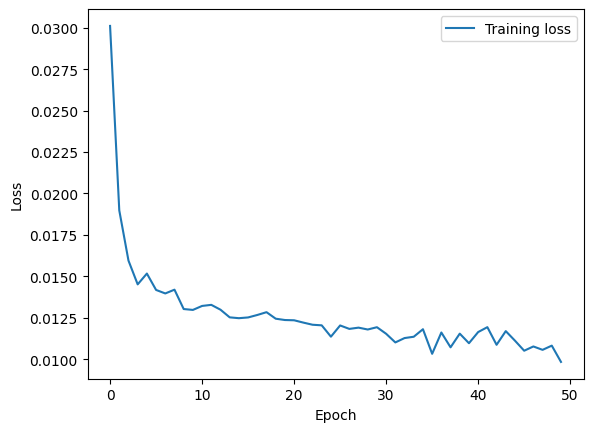

In [45]:
def mean_magnitude_relative_error(y_true, y_pred):
    # Calculate relative error
    relative_error = np.abs((y_true - y_pred) / y_true)
    
    # Calculate mean magnitude of relative error (MMRE)
    mmre = np.mean(relative_error)
    
    return mmre

if __name__ == "__main__":
    # Load or generate your data
    X, y = data_china()

    # Assuming trainX and trainY are defined appropriately
    trainX = X[:400]  # Example: using first 400 samples for training
    trainY = y[:400]  # Example: using first 400 targets for training
    testX = X[400:]   # Example: using remaining samples for testing
    testY = y[400:]   # Example: using remaining targets for testing

    # Create the Wavelet Neural Network
    input_shape = trainX.shape[1:]  # Assuming trainX.shape is (496, 2, 18), input_shape should be (2, 18)
    wnn = Sequential([
        BatchNormalization(input_shape=input_shape),
        MorletWaveletLayer(filters=16,  f0=1.115, sigma=1.47),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
          # Replace with appropriate units for your use case
        Dense(10),
        Flatten(),
        Dense(1)  # Adjust output dim to match trainY.shape[1]
    ])

    # Compile the model
    wnn.compile(optimizer='adam', loss='mse')
    wnn.summary()

    # Train the model
    history = wnn.fit(trainX, trainY, epochs=50, batch_size=32, validation_split=0.0, verbose=1)

    # Evaluate the model on test data
    predictions = wnn.predict(testX)

    # Calculate evaluation metrics
    mae = mean_absolute_error(testY, predictions)
    mse = mean_squared_error(testY, predictions)
    r2 = r2_score(testY, predictions)
    mmre = mean_magnitude_relative_error(testY, predictions)

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared (R2) Score: {r2:.4f}")
    print(f"Mean Magnitude of Relative Error (MMRE): {mmre:.4f}")

    # Plot training history
    plt.plot(history.history['loss'], label='Training loss')
    #plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [37]:
pre=wnn.predict(testX)

3/3 [==============================] - 0s 2ms/step


In [32]:
wnn=None

In [38]:
pre.shape

(96, 1)

In [39]:
trainY.shape

(400, 1)

In [40]:
mse = mean_squared_error(testY, pre)

In [41]:
mse

0.021960801772131947

In [ ]:
# Assuming testX and testY are defined appropriately
testX = X[400:]   # Example: using remaining samples for testing
testY = y[400:]   # Example: using remaining targets for testing

# Evaluate the model on test data
predictions = wnn.predict(testX)

# Reshape predictions and testY if necessary
if predictions.ndim > 2:
    predictions = np.squeeze(predictions)
if testY.ndim > 2:
    testY = np.squeeze(testY)

# Calculate evaluation metrics
mae = np.mean(np.abs(predictions - testY))
mse = np.mean((predictions - testY)**2)
r2 = r2_score(testY, predictions)
mmre = mean_magnitude_relative_error(testY, predictions)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2) Score: {r2:.4f}")
print(f"Mean Magnitude of Relative Error (MMRE): {mmre:.4f}")


# LSTM Model

In [ ]:
trainX, trainY = data_china()


print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

# define the Autoencoder model

model = Sequential()
model.add(BatchNormalization(input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True)))
model.add(LSTM(32, activation='relu',))
model.add(Dropout(0.1))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='sgd', loss='mse')
model.summary()


# fit the model
history = model.fit(trainX, trainY, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')


In [ ]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


In [ ]:
# trainY.shape[1]

In [ ]:
trainX, trainY = data_china()
# def create_and_train_autoencoder(trainX, trainY, epochs, batch_size, validation_split, 
#                                  learning_rate, dropout_rate, activation, 
#                                  optimizer, loss):
    
#     model = Sequential()
#     model.add(BatchNormalization(input_shape=(trainX.shape[1], trainX.shape[2])))
#     model.add(Bidirectional(LSTM(64, activation=activation, return_sequences=True)))
#     model.add(LSTM(32, activation=activation, return_sequences=False))
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(trainY.shape[1]))

#     model.compile(optimizer=optimizer, loss=loss)
#     model.summary()


#     # fit the model
#     history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=1)

#     plt.plot(history.history['loss'], label='Training loss')
#     plt.plot(history.history['val_loss'], label='Validation loss')

#     return model, history

def create_and_train_autoencoder(trainX, trainY, epochs, batch_size, validation_split, 
                                 learning_rate, dropout_rate, lstm_units, activation, 
                                 optimizer, loss):
    
    model = Sequential()
    model.add(BatchNormalization(input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Bidirectional(LSTM(lstm_units, activation=activation, return_sequences=True)))
    model.add(LSTM(lstm_units // 2, activation=activation, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(Dense(trainY.shape[1]))



    
    model.compile(optimizer=optimizer, loss=loss)
    model.summary()

    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # fit the model with early stopping
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, 
                        validation_split=validation_split, verbose=1, callbacks=[early_stopping])
   
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')

    return model, history


# Example usage:
# Adjust hyperparameters as needed
# autoencoder_model, training_history = create_and_train_autoencoder(trainX, trainY, 
#                                                                     epochs=500, batch_size=32, 
#                                                                     validation_split=0.1, 
#                                                                     learning_rate=best_hyperparameters[0], 
#                                                                     dropout_rate=best_hyperparameters[1], 
#                                                                     lstm_units=int(best_hyperparameters[2]),
#                                                                     activation='relu', 
#                                                                     optimizer='adam', 
#                                                                     loss='mse')

autoencoder_model, training_history = create_and_train_autoencoder(trainX, trainY, 
                                                                    epochs=100, batch_size=16, 
                                                                    validation_split=0.1, 
                                                                    learning_rate=0.01, 
                                                                    dropout_rate=0.1,
                                                                    lstm_units= 64,
                                                                    activation='sigmoid', 
                                                                    optimizer='adam', 
                                                                    loss= 'mae',
                                                                    
                                                                  )

In [ ]:
import numpy as np

def harmonic_search(objective_function, search_space, num_iterations):
    # Initialize parameters
    num_harmonics = 10
    pitch_adjustment_rate = 0.01

    # Initialize random solutions within the search space
    solutions = np.random.uniform(low=search_space[:, 0], high=search_space[:, 1], size=(num_harmonics, len(search_space)))

    for iteration in range(num_iterations):
        # Evaluate the performance of each solution
        scores = [objective_function(solution) for solution in solutions]

        # Select the top-performing solutions as parents
        parents = solutions[np.argsort(scores)[:2]]

        # Generate new candidate solutions by combining and modifying parents
        new_solutions = parents[0] + np.random.uniform(low=-pitch_adjustment_rate, high=pitch_adjustment_rate, size=parents.shape)

        # Clip new solutions to the search space
        new_solutions = np.clip(new_solutions, search_space[:, 0], search_space[:, 1])

        # Replace the worst solutions with the new ones
        worst_index = np.argmax(scores)
        solutions[worst_index] = new_solutions[0]  # Take the first parent as the new solution

    # Return the best solution found
    best_solution = solutions[np.argmin(scores)]
    return best_solution

# Example usage:
# Define the search space for hyperparameters
search_space = np.array([
    [0.001, 0.1],  # Learning Rate
    [0.1, 0.9],    # Dropout Rate
    [16, 64],     # Number of LSTM units
])

# Define your objective function (replace with your actual training and evaluation logic)
def objective_function(hyperparameters):
    learning_rate, dropout_rate, lstm_units = hyperparameters
    
    try:
        # Create and train LSTM model with the given hyperparameters
        # Return the performance metric to be minimized (e.g., validation loss)
        autoencoder_model, training_history = create_and_train_autoencoder(trainX, trainY, 
                                                                            epochs=100, batch_size=16, 
                                                                            validation_split=0.1, 
                                                                            learning_rate=learning_rate, 
                                                                            dropout_rate=dropout_rate, 
                                                                            lstm_units=int(lstm_units),
                                                                            activation='sigmoid', 
                                                                            optimizer='adam')
        
        # Retrieve the performance metric (e.g., validation loss) from the training history
        metric = min(training_history.history['val_loss'])  # Assuming 'val_loss' is the relevant metric

        return metric
    except Exception as e:
        # Return a large value in case of an error
        return float('inf')

# Run harmonic search
best_hyperparameters = harmonic_search(objective_function, search_space, num_iterations=50)

# Print or log the best hyperparameters
print("Best Hyperparameters:")
print("Learning Rate:", best_hyperparameters[0])
print("Dropout Rate:", best_hyperparameters[1])
print("LSTM Units:", int(best_hyperparameters[2]))

# Update your LSTM model with the best hyperparameters
autoencoder_model, training_history = create_and_train_autoencoder(trainX, trainY, 
                                                                    epochs=100, batch_size=16, 
                                                                    validation_split=0.1, 
                                                                    learning_rate=best_hyperparameters[0], 
                                                                    dropout_rate=best_hyperparameters[1], 
                                                                    lstm_units=int(best_hyperparameters[2]),
                                                                    activation='sigmoid', 
                                                                    optimizer='adam', 
                                                                    loss='mae',
                                                                    
                                                                  )

# Optionally, you can also print or log other relevant information, such as the best performance metric
best_metric = objective_function(best_hyperparameters)
print("Best Performance Metric:", best_metric)


In [ ]:

#     from sklearn.preprocessing import MinMaxScaler
#     df = pd.read_csv(CFG[1])
# #     x = df.drop(columns=['id','ID'])
#     # Assuming your dataset is stored in a DataFrame named 'df'
#     # If not, replace 'df' with the actual name of your DataFrame

#     # Extract the target variable
#     target_variable = 'Effort'
#     y = df[target_variable]

#     # Extract features (excluding target variable)
#     X = df.drop(columns=['id','ID', 'Effort'])

#     # Normalize the dataset
#     scaler = MinMaxScaler()
#     X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

#     # Split the dataset into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

#     # Check the shapes of the resulting sets
#     print("X_train shape:", X_train.shape)
#     print("X_test shape:", X_test.shape)
#     print("y_train shape:", y_train.shape)
#     print("y_test shape:", y_test.shape)
# df

In [ ]:
# from sklearn import datasets
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVR
# from sklearn.metrics import  mean_absolute_error



# # Create an SVM regressor
# svm_regressor = SVR(kernel='linear', C=1)

# svm_regressor.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = svm_regressor.predict(X_test)

# # Evaluate mean squared error
# mae = mean_absolute_error(y_test, y_pred)
# print(f"Mean Squared Error: {mae}")


In [ ]:
# trainX.shape

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Activation
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
df = pd.read_csv(CFG[1])
# Load your dataset (assuming it's in a DataFrame named 'df')
# Replace 'Effort' with the actual column name you want to predict
target_column = 'Effort'

# Separate features (X) and target variable (y)
X = df.drop(target_column, axis=1)
y = df[target_column]

# Data Preprocessing
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_normalized = scaler_X.fit_transform(X.values)
y_normalized = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Reshape X for LSTM input (assuming you have a sequence length)
sequence_length = 1  # Adjust based on your dataset
X_reshaped = X_normalized.reshape((X_normalized.shape[0], sequence_length, X_normalized.shape[1]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_normalized, test_size=0.2, random_state=42)

# Model Construction and Training
inp = Input(shape=(X_reshaped.shape[1], X_reshaped.shape[2]))
e = Sequential()(inp)
g = LSTM(units=64, return_sequences=True)(e)
h = LSTM(units=32, return_sequences=True)(g)
s = Attention(use_scale=True)([h, h])
f = Activation('relu')(s)
out = Dense(1)(f)  # Assuming a regression task

model = Model(inputs=inp, outputs=out)
model.compile(optimizer='adam', loss='mean_squared_error')  # You can use other loss functions for regression

# Implement Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model and monitor the training history
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Prediction
y_pred = model.predict(X_test)

# Rescale predictions to the original scale
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Rescale true labels to the original scale
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluate mean absolute error
mae = np.mean(np.abs(y_test_rescaled - y_pred_rescaled))
print(f"Mean Absolute Error: {mae}")


In [ ]:
df = pd.read_csv(CFG[1])
# df = df.drop(columns=['id','ID'])
df.shape

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
import optuna

df = pd.read_csv(CFG[7])
# df = df.drop(columns=['id','ID'])
# Load your dataset (assuming it's in a DataFrame named 'df')
# Replace 'Effort' with the actual column name you want to predict
target_column = 'Effort'

# Separate features (X) and target variable (y)
X = df.drop(target_column, axis=1)
y = df[target_column]

# Data Preprocessing
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_normalized = scaler_X.fit_transform(X.values)
y_normalized = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Reshape X for LSTM input (assuming you have a sequence length)
sequence_length = 1  # Adjust based on your dataset
X_reshaped = X_normalized.reshape((X_normalized.shape[0], sequence_length, X_normalized.shape[1]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_normalized, test_size=0.2, random_state=42)

# Model Construction and Training
def build_model(units1, units2, learning_rate):
    inp = Input(shape=(X_reshaped.shape[1], X_reshaped.shape[2]))
    e = Sequential()(inp)
    g = LSTM(units=units1, return_sequences=True)(e)
    h = LSTM(units=units2, return_sequences=True)(g)
    s = Attention(use_scale=True)([h, h])
    f = Activation('relu')(s)
    out = Dense(1)(f)  # Assuming a regression task

    model = Model(inputs=inp, outputs=out)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')  # You can use other loss functions for regression
    
    return model

# Implement Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Objective function for Optuna
def objective(trial):
    units1 = trial.suggest_int('units1', 32, 128)
    units2 = trial.suggest_int('units2', 16, 64)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)

    model = build_model(units1=units1, units2=units2, learning_rate=learning_rate)
    
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    return mean_absolute_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)), scaler_y.inverse_transform(model.predict(X_test).reshape(-1, 1)))

# Perform hyperparameter tuning with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params

# Train the final model with the best hyperparameters
best_model = build_model(**best_params)
best_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Plot the training and validation loss
plt.plot(best_model.history.history['loss'], label='Train Loss')
plt.plot(best_model.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Prediction
y_pred = best_model.predict(X_test)

# Rescale predictions to the original scale
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Rescale true labels to the original scale
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluate mean absolute error
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f"Mean Absolute Error: {mae}")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Activation
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load your dataset (assuming it's in a DataFrame named 'df')
# Replace 'Effort' with the actual column name you want to predict
target_column = 'Effort'

# Separate features (X) and target variable (y)
X = df.drop(target_column, axis=1)
y = df[target_column]

# Data Preprocessing
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_normalized = scaler_X.fit_transform(X.values)
y_normalized = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Reshape X for LSTM input (assuming you have a sequence length)
sequence_length = 1  # Adjust based on your dataset
X_reshaped = X_normalized.reshape((X_normalized.shape[0], sequence_length, X_normalized.shape[1]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_normalized, test_size=0.2, random_state=42)

# Model Construction and Training
inp = Input(shape=(X_reshaped.shape[1], X_reshaped.shape[2]))
e = Sequential()(inp)
g = LSTM(units=64, return_sequences=True)(e)
h = LSTM(units=32, return_sequences=True)(g)
s = Attention(use_scale=True)([h, h])
f = Activation('relu')(s)
out = Dense(1)(f)  # Assuming a regression task

model = Model(inputs=inp, outputs=out)
model.compile(optimizer='adam', loss='mean_squared_error')  # You can use other loss functions for regression

# Implement Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model and monitor the training history
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Prediction
y_pred = model.predict(X_test)

# Rescale predictions to the original scale
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Rescale true labels to the original scale
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluate root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"Root Mean Squared Error (RMSE): {rmse}")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error
import optuna

# Load your dataset (assuming it's in a DataFrame named 'df')
# Replace 'Effort' with the actual column name you want to predict
target_column = 'Effort'

# Separate features (X) and target variable (y)
X = df.drop(target_column, axis=1)
y = df[target_column]

# Data Preprocessing
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_normalized = scaler_X.fit_transform(X.values)
y_normalized = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Reshape X for LSTM input (assuming you have a sequence length)
sequence_length = 1  # Adjust based on your dataset
X_reshaped = X_normalized.reshape((X_normalized.shape[0], sequence_length, X_normalized.shape[1]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_normalized, test_size=0.2, random_state=42)

# Model Construction and Training
def build_model(units1, units2, learning_rate):
    inp = Input(shape=(X_reshaped.shape[1], X_reshaped.shape[2]))
    e = Sequential()(inp)
    g = LSTM(units=units1, return_sequences=True)(e)
    h = LSTM(units=units2, return_sequences=True)(g)
    s = Attention(use_scale=True)([h, h])
    f = Activation('relu')(s)
    out = Dense(1)(f)  # Assuming a regression task

    model = Model(inputs=inp, outputs=out)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')  # You can use other loss functions for regression
    
    return model

# Implement Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Objective function for Optuna
def objective(trial):
    units1 = trial.suggest_int('units1', 32, 128)
    units2 = trial.suggest_int('units2', 16, 64)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)

    model = build_model(units1=units1, units2=units2, learning_rate=learning_rate)
    
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    return mean_absolute_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)), scaler_y.inverse_transform(model.predict(X_test).reshape(-1, 1)))

# Perform hyperparameter tuning with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params

# Train the final model with the best hyperparameters
best_model = build_model(**best_params)
best_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Plot the training and validation loss
plt.plot(best_model.history.history['loss'], label='Train Loss')
plt.plot(best_model.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Prediction
y_pred = best_model.predict(X_test)

# Rescale predictions to the original scale
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Rescale true labels to the original scale
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluate root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"Root Mean Squared Error (RMSE): {rmse}")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error, r2_score
import optuna

# Load your dataset (assuming it's in a DataFrame named 'df')
# Replace 'Effort' with the actual column name you want to predict
target_column = 'Effort'

# Separate features (X) and target variable (y)
X = df.drop(target_column, axis=1)
y = df[target_column]

# Data Preprocessing
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_normalized = scaler_X.fit_transform(X.values)
y_normalized = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Reshape X for LSTM input (assuming you have a sequence length)
sequence_length = 1  # Adjust based on your dataset
X_reshaped = X_normalized.reshape((X_normalized.shape[0], sequence_length, X_normalized.shape[1]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_normalized, test_size=0.2, random_state=42)

# Model Construction and Training
def build_model(units1, units2, learning_rate):
    inp = Input(shape=(X_reshaped.shape[1], X_reshaped.shape[2]))
    e = Sequential()(inp)
    g = LSTM(units=units1, return_sequences=True)(e)
    h = LSTM(units=units2, return_sequences=True)(g)
    s = Attention(use_scale=True)([h, h])
    f = Activation('relu')(s)
    out = Dense(1)(f)  # Assuming a regression task

    model = Model(inputs=inp, outputs=out)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')  # You can use other loss functions for regression
    
    return model

# Implement Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Objective function for Optuna
def objective(trial):
    units1 = trial.suggest_int('units1', 32, 128)
    units2 = trial.suggest_int('units2', 16, 64)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)

    model = build_model(units1=units1, units2=units2, learning_rate=learning_rate)
    
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    return mean_absolute_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)), scaler_y.inverse_transform(model.predict(X_test).reshape(-1, 1)))

# Perform hyperparameter tuning with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params

# Train the final model with the best hyperparameters
best_model = build_model(**best_params)
best_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Plot the training and validation loss
plt.plot(best_model.history.history['loss'], label='Train Loss')
plt.plot(best_model.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Prediction
y_pred = best_model.predict(X_test)

# Rescale predictions to the original scale
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Rescale true labels to the original scale
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluate R-squared
r_squared = r2_score(y_test_rescaled, y_pred_rescaled)
print(f"R-squared: {r_squared}")
